In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from IPython.display import display
import copy
import time
import matplotlib.pyplot as plt

In [16]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Helper Functions

In [18]:
def transform_data(data_features, data_target, preprocess):
    data_target_transformed = np.log(data_target)

    data_features_transformed = preprocess.transform(data_features)

    data_features_tensor = torch.tensor(data_features_transformed.toarray(), dtype=torch.float32).to(device)
    data_target_tensor = torch.tensor(data_target_transformed.values, dtype=torch.float32).reshape(-1, 1).to(device)

    print("\nData transformed.\n")

    return data_features_tensor, data_target_tensor

def save_checkpoint(model, optimizer, loss_history, best_model_loss, best_model_state, model_file_location):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'best_model_state_dict': best_model_state,
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss,
        'best_loss': best_model_loss,
        'loss_history': loss_history
    }

    # Save the checkpoint dictionary to a file
    torch.save(checkpoint, model_file_location)

    print(f"Checkpoint saved to {model_file_location}.")

# Getting, Cleaning, Preprocessing the Data

In [5]:
data = pd.read_excel('/content/drive/MyDrive/Property Sales Data/nycdof/2023to2024_brooklyn_sales.xlsx',skiprows = 0)

print("Data shape: ",data.shape)
print(f"{len(data.columns)} Columns: {data.columns}")

Data shape:  (43631, 21)
21 Columns: Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL\nUNITS', 'COMMERCIAL\nUNITS', 'TOTAL \nUNITS',
       'LAND \nSQUARE FEET', 'GROSS \nSQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS\nAT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')


In [6]:
print(data.isna().sum())

BOROUGH                                2
NEIGHBORHOOD                           2
BUILDING CLASS CATEGORY                2
TAX CLASS AT PRESENT                   2
BLOCK                                  2
LOT                                    2
EASE-MENT                          43631
BUILDING CLASS AT PRESENT              2
ADDRESS                                2
APARTMENT NUMBER                   32624
ZIP CODE                               3
RESIDENTIAL\nUNITS                  7037
COMMERCIAL\nUNITS                  14020
TOTAL \nUNITS                       5085
LAND \nSQUARE FEET                 15972
GROSS \nSQUARE FEET                15972
YEAR BUILT                          2791
TAX CLASS AT TIME OF SALE              2
BUILDING CLASS\nAT TIME OF SALE        2
SALE PRICE                             2
SALE DATE                              2
dtype: int64


In [7]:
# Drop EASE-MENT, APARTMENT NUMBER, COMMERCIAL\nUNITS
data = data.drop(['EASE-MENT', 'APARTMENT NUMBER', 'BUILDING CLASS AT PRESENT','ADDRESS','LOT','TAX CLASS AT PRESENT', 'BLOCK', 'BOROUGH'], axis=1)

print(f"{len(data.columns)} Columns: {data.columns}")

13 Columns: Index(['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'ZIP CODE',
       'RESIDENTIAL\nUNITS', 'COMMERCIAL\nUNITS', 'TOTAL \nUNITS',
       'LAND \nSQUARE FEET', 'GROSS \nSQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS\nAT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')


In [8]:
print("Size before dropping rows: ", data.shape[0])

data = data.dropna(how='all')

print("Size after dropping empty rows: ", data.shape[0])

data = data[data['SALE PRICE'] != 0]

print("Size after dropping rows with $0 sale price: ", data.shape[0])

display(data.head())
print(data.shape)

Size before dropping rows:  43631
Size after dropping empty rows:  43629
Size after dropping rows with $0 sale price:  27019


,NEIGHBORHOOD,BUILDING CLASS CATEGORY,ZIP CODE,RESIDENTIAL\nUNITS,COMMERCIAL\nUNITS,TOTAL \nUNITS,LAND \nSQUARE FEET,GROSS \nSQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS\nAT TIME OF SALE,SALE PRICE,SALE DATE
2,BATH BEACH,01 ONE FAMILY DWELLINGS,11228.0,1.0,0.0,1.0,1547.0,1428.0,1930.0,1.0,A5,925000.0,2023-08-03
3,BATH BEACH,01 ONE FAMILY DWELLINGS,11228.0,1.0,0.0,1.0,2900.0,1660.0,1930.0,1.0,A5,1275000.0,2023-12-07
4,BATH BEACH,01 ONE FAMILY DWELLINGS,11228.0,1.0,0.0,1.0,2280.0,1052.0,1901.0,1.0,A9,825000.0,2023-03-31
5,BATH BEACH,01 ONE FAMILY DWELLINGS,11214.0,1.0,1.0,2.0,1342.0,1920.0,1926.0,1.0,S1,1505000.0,2023-04-21
6,BATH BEACH,01 ONE FAMILY DWELLINGS,11214.0,1.0,1.0,2.0,1342.0,1920.0,1926.0,1.0,S1,1650000.0,2023-09-08


(27019, 13)


In [9]:
# Fill the LAND \nSQUARE FEET and GROSS \nSQUARE FEET with value 0 since they are condos or coops
data['LAND \nSQUARE FEET'] = data['LAND \nSQUARE FEET'].fillna(0)
data['GROSS \nSQUARE FEET'] = data['GROSS \nSQUARE FEET'].fillna(0)

# Fill UNITS with 0 if there are no residential or commerical units or both
data['RESIDENTIAL\nUNITS'] = data['RESIDENTIAL\nUNITS'].fillna(0)
data['COMMERCIAL\nUNITS'] = data['COMMERCIAL\nUNITS'].fillna(0)
data['TOTAL \nUNITS'] = data['TOTAL \nUNITS'].fillna(0)

# Fill year built with the average year built
data['YEAR BUILT'] = data['YEAR BUILT'].fillna(data['YEAR BUILT'].mean())

data['ZIP CODE'] = data['ZIP CODE'].fillna("Unknown").astype(str)

print(data.isna().sum())

NEIGHBORHOOD                       0
BUILDING CLASS CATEGORY            0
ZIP CODE                           0
RESIDENTIAL\nUNITS                 0
COMMERCIAL\nUNITS                  0
TOTAL \nUNITS                      0
LAND \nSQUARE FEET                 0
GROSS \nSQUARE FEET                0
YEAR BUILT                         0
TAX CLASS AT TIME OF SALE          0
BUILDING CLASS\nAT TIME OF SALE    0
SALE PRICE                         0
SALE DATE                          0
dtype: int64


## Preprocessing

In [10]:
data_features = data.copy()
data_features['SALE_YEAR'] = (data_features['SALE DATE']).dt.year
data_features['SALE_MONTH'] = (data_features['SALE DATE']).dt.month
data_features['SALE_DAY'] = (data_features['SALE DATE']).dt.day
data_features.drop(['SALE PRICE', 'SALE DATE'], axis=1, inplace = True)

data_target = data['SALE PRICE']
data_target_transformed = np.log(data_target)

In [19]:
numerical_columns = []
categorical_columns = []

for column in data_features.columns:
    if data_features[column].dtype == 'object':
        categorical_columns.append(column)
    # if column is in the list then evaluate true
    elif column in ['TAX CLASS AT TIME OF SALE','SALE_MONTH']:
        categorical_columns.append(column)
    else:
        numerical_columns.append(column)


print("Numerical Features: ", numerical_columns)
print("Categorical Features: ", categorical_columns)

Numerical Features:  ['RESIDENTIAL\nUNITS', 'COMMERCIAL\nUNITS', 'TOTAL \nUNITS', 'LAND \nSQUARE FEET', 'GROSS \nSQUARE FEET', 'YEAR BUILT', 'SALE_YEAR', 'SALE_DAY']
Categorical Features:  ['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'ZIP CODE', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS\nAT TIME OF SALE', 'SALE_MONTH']


In [20]:
preprocess = ColumnTransformer([
    ('num', StandardScaler(), numerical_columns),
    ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_columns)
])

preprocess.fit(data_features)

data_features_tensor, data_target_tensor = transform_data(data_features, data_target, preprocess)


Data transformed.



# Model

In [24]:
class HouseNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(288, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        self.dropout(x)
        x = self.fc4(x)
        x = self.relu(x)
        self.dropout(x)
        x = self.fc5(x)

        return x

In [25]:
model = HouseNeuralNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

print(model)

HouseNeuralNet(
  (fc1): Linear(in_features=288, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


In [26]:
batch_size = 512
num_epochs = 10000
best_model_state = None
best_model_loss = float('inf')
loss_history = []

start_time = time.time()
model.train()

# --- Training Loop ---
for epoch in range(num_epochs):
    permutation = torch.randperm(data_features_tensor.size(0))
    epoch_loss = 0.0

    for i in range(0, data_features_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = data_features_tensor[indices]
        batch_y = data_target_tensor[indices]

        optimizer.zero_grad(set_to_none=True)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= (data_features_tensor.size(0) // batch_size)
    loss_history.append(epoch_loss)

    if (epoch_loss < best_model_loss):
        best_model_loss = epoch_loss
        best_model_state = copy.deepcopy(model.state_dict())
        if (epoch > num_epochs/2):
            print(f"New best model found at epoch {epoch} with loss {epoch_loss}.")

    # Print occasionally
    if (epoch + 1) % 500 == 0:
        elapsed = time.time() - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.6f} - Time: {elapsed:.2f}s")

Epoch [500/10000] - Loss: 0.551362 - Time: 71.40s
Epoch [1000/10000] - Loss: 0.409647 - Time: 153.15s
Epoch [1500/10000] - Loss: 0.303137 - Time: 214.64s
Epoch [2000/10000] - Loss: 0.274254 - Time: 269.10s
Epoch [2500/10000] - Loss: 0.246521 - Time: 324.28s
Epoch [3000/10000] - Loss: 0.203904 - Time: 382.04s
Epoch [3500/10000] - Loss: 0.162534 - Time: 459.30s
Epoch [4000/10000] - Loss: 0.153397 - Time: 533.77s
Epoch [4500/10000] - Loss: 0.151042 - Time: 604.04s
Epoch [5000/10000] - Loss: 0.143958 - Time: 669.77s
New best model found at epoch 5003 with loss 0.11199975278801642.
New best model found at epoch 5004 with loss 0.1071560259263676.
New best model found at epoch 5476 with loss 0.10611923848493741.
New best model found at epoch 5491 with loss 0.10461643219997104.
Epoch [5500/10000] - Loss: 0.127770 - Time: 732.32s
New best model found at epoch 5530 with loss 0.10070271456900698.
New best model found at epoch 5698 with loss 0.10001115715847565.
New best model found at epoch 5699 

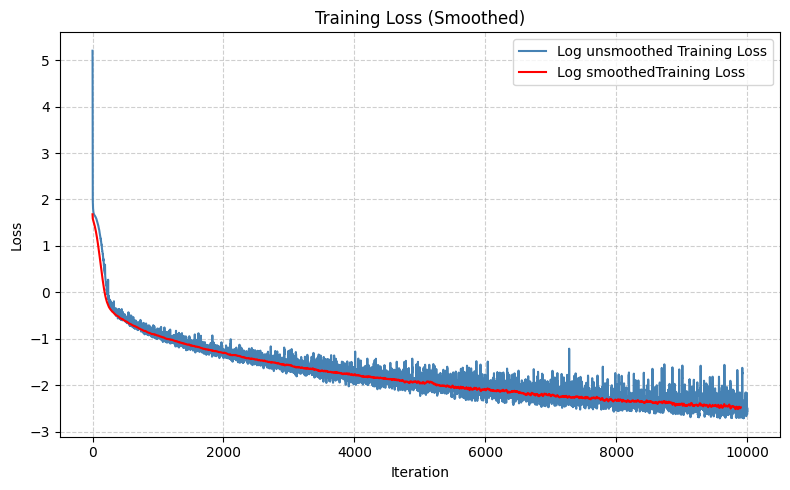

In [27]:
plt.figure(figsize=(8,5))

plt.plot(np.log(loss_history), color='steelblue', label = 'Log unsmoothed Training Loss')

window = 100
smooth = np.convolve(np.log(loss_history), np.ones(window)/window, mode='valid')

plt.plot(smooth, label='Log smoothedTraining Loss', color='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss (Smoothed)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
data_features['BUILDING CLASS\nAT TIME OF SALE'].unique()

array(['A5', 'A9', 'S1', 'A2', 'S0', 'B1', 'B3', 'B2', 'B9', 'S2', 'C0',
       'R3', 'C3', 'C2', 'C6', 'D4', 'R2', 'R4', 'S9', 'R1', 'R8', 'K2',
       'R5', 'E1', 'V1', 'P9', 'RP', 'A1', 'A4', 'A3', 'V0', 'C1', 'C7',
       'D1', 'S5', 'S3', 'O8', 'O6', 'K1', 'K4', 'K5', 'H3', 'H6', 'M1',
       'RB', 'RG', 'RS', 'R6', 'G0', 'C4', 'D5', 'D7', 'S4', 'R9', 'O7',
       'O1', 'F5', 'G9', 'I9', 'M3', 'Z9', 'RA', 'G2', 'O2', 'RH', 'RK',
       'RT', 'D6', 'O5', 'K7', 'F4', 'F9', 'G7', 'G1', 'E2', 'E9', 'W2',
       'P5', 'M9', 'C5', 'D9', 'W6', 'HR', 'H4', 'I6', 'G6', 'D3', 'D0',
       'RR', 'I7', 'I5', 'Z0', 'H2', 'K6', 'F1', 'F2', 'J8', 'N2', 'E7',
       'W9', 'V2', 'A7', 'R7', 'W3', 'A0', 'W8', 'O9', 'J1', 'RW', 'G8',
       'GU', 'G4', 'Q9', 'G3', 'P6', 'C8', 'GW', 'Z7', 'Z3', 'N9', 'HB',
       'D2'], dtype=object)

# Predictions

In [41]:
test_data = [
    ['CARROLL GARDENS', '03 THREE FAMILY DWELLINGS', '11231.0', 3.0, 0.0, 3.0, 2000.0, 2700.0, 1899.000000, 1.0, 'C0', 2024, 6, 17],
    ['SHEEPSHEAD BAY', '02 TWO FAMILY DWELLINGS','11229.0', 2.0, 0.0, 2.0, 2200.0, 1890.0, 1940.000000, 1.0, 'B9', 2024, 11, 13]
]
# []
test_data = pd.DataFrame(test_data, columns = data_features.columns)
test_data['SALE_YEAR'] = test_data['SALE_YEAR'].astype('int32')
test_data['SALE_MONTH'] = test_data['SALE_MONTH'].astype('int32')
test_data['SALE_DAY'] = test_data['SALE_DAY'].astype('int32')
display(test_data)

test_data_tranformed = preprocess.transform(test_data)
test_data_tensor = torch.tensor(test_data_tranformed.toarray(), dtype=torch.float32).to(device)

,NEIGHBORHOOD,BUILDING CLASS CATEGORY,ZIP CODE,RESIDENTIAL\nUNITS,COMMERCIAL\nUNITS,TOTAL \nUNITS,LAND \nSQUARE FEET,GROSS \nSQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS\nAT TIME OF SALE,SALE_YEAR,SALE_MONTH,SALE_DAY
0,CARROLL GARDENS,03 THREE FAMILY DWELLINGS,11231.0,3.0,0.0,3.0,2000.0,2700.0,1899.0,1.0,C0,2024,6,17
1,SHEEPSHEAD BAY,02 TWO FAMILY DWELLINGS,11229.0,2.0,0.0,2.0,2200.0,1890.0,1940.0,1.0,B9,2024,11,13


In [42]:
model.eval()

with torch.no_grad():
    print(np.exp(model(test_data_tensor).cpu().numpy()))

[[2356573. ]
 [1231642.2]]


# Save Model


In [43]:
checkpoint = {
    'epoch': epoch + 1,
    'model_state_dict': model.state_dict(),
    'best_model_state_dict': best_model_state,
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': epoch_loss,
    'best_loss': best_model_loss
}

# Save the checkpoint dictionary to a file
torch.save(checkpoint, '/content/drive/MyDrive/Unsorted Items/training_checkpoint_initial.pth')